# Ensemble Methods in Machine Learning
## Hands-on exercises for the Machine Learning Journal Club

##### Nuno R. C. Gomes, IEEC/ICE-CSIC, 2026/02/13

This notebook explores ensemble learning techniques using
astrophysics-related data sets.
We will compare five different approaches:

1. **Decision Tree** (baseline)
2. **Bagging**
3. **Random Forest**
4. **XGBoost**
5. **Stacking**

We will evaluate these methods on both classification (exoplanet detection) and
regression (stellar luminosity) tasks.

---

## Setup and imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import (
  make_classification,
  make_regression
)
from sklearn.ensemble import (
  BaggingClassifier,
  BaggingRegressor,
  RandomForestClassifier,
  RandomForestRegressor,
  StackingClassifier,
  StackingRegressor
)
from sklearn.linear_model import (
  LogisticRegression,
  LinearRegression
)
from sklearn.metrics import (
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  roc_auc_score,
  confusion_matrix,
  mean_squared_error,
  r2_score,
  mean_absolute_error
)
from sklearn.model_selection import (
  train_test_split,
  cross_val_score,
  KFold,
  StratifiedKFold
)
from sklearn.neighbors import (
  KNeighborsClassifier,
  KNeighborsRegressor
)
from sklearn.preprocessing import (
  StandardScaler,
  LabelEncoder
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# set random seed for reproducibility
RND_STATE = 42
np.random.seed(RND_STATE)

# set visualisation style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

---

## Part I: Classification Task
### 1. Exoplanet detection

We simulate a data set of exoplanet candidates based on characteristics similar
to Kepler observations: planetary radius, orbital period, stellar mass, and
equilibrium temperature.
The task is to classify whether a candidate is a true exoplanet or a false
positive.

**Context**

Modern exoplanet detection methods (transit, radial velocity,
direct imaging) produce numerous candidates.
Machine learning helps identify genuine planets from noise and instrumental
artefacts.

#### 1.1 Generate mock exoplanet data set

In [2]:
# generate synthetic exoplanet data set for imbalanced classification problem
X_class, y_class = make_classification(
  n_samples=1000,
  n_features=8,
  n_informative=6,
  n_redundant=2,
  n_clusters_per_class=2,
  flip_y=0.1,
  random_state=RND_STATE,
  weights=[0.6, 0.4],
)

feature_names = [
  "rad_planet",   # planetary radius (Earth radii)
  "peri_orb",     # orbital period (days)
  "star_mass",    # stellar mass (Solar masses)
  "temp_equil",   # equilibrium temperature (K)
  "trans_depth",  # transit depth (ppm)
  "sai",          # stellar activity index
  "rv_semi_amp",  # RV semi-amplitude (m/s)
  "snr"           # signal-to-noise ratio
]
X_class_df = pd.DataFrame(X_class, columns=feature_names)

title = "RAW DATA SET"
lenti = len(title)
print("="*lenti)
print(title)
print("-"*lenti + '\n')
print("Features")
print("-"*8)
print(f"Shape: {X_class.shape}\n")
print(X_class_df.head())
print(f"\nTarget")
print("-"*6)
print(f"{y_class[:5] = }")
print(f"{y_class[-5:] = }")
print('='*80)

RAW DATA SET
------------

Features
--------
Shape: (1000, 8)

   rad_planet  peri_orb  star_mass  temp_equil  trans_depth       sai  \
0   -0.629770  1.218823   1.851539    0.995196     0.025862  0.081595   
1   -3.637625  0.229661   1.590702    2.085496    -0.057291  2.609662   
2   -1.742110  0.334368  -2.862792   -0.607019     0.494717  3.564179   
3   -0.101457 -1.133519   1.618456   -0.815398     0.521562 -0.607144   
4    0.012285  1.232229   1.396173    0.969232    -0.337348  0.214862   

   rv_semi_amp       snr  
0     0.584405 -0.385715  
1    -2.249409  0.748441  
2    -0.873165 -3.724358  
3    -0.913324  2.030949  
4     0.296557 -0.535179  

Target
------
y_class[:5] = array([1, 0, 0, 1, 0])
y_class[-5:] = array([0, 0, 1, 0, 0])


##### Notes

- `n_informative=6` creates six features with genuine class-separating signal —
  models can use these to achieve good accuracy.
- `n_redundant=2` generates two extra features as random linear combinations of
  the informative ones (e.g., feat7 = 0.3·feat1 + 0.7·feat2), so they correlate
  with classes but add no new info.
- `n_clusters_per_class=2` places each class's data in two separate Gaussian
  clusters (blobs) in feature space, separated by `class_sep` distance — makes
  the problem geometrically structured rather than a single blob per class.
- `flip_y=0.1` randomly flips 10% of true labels (e.g., class 0 → 1),
  introducing label noise to simulate real-world errors and make the task
  harder.
- `weights=[0.6, 0.4]` controls the class imbalance ratio in the generated data
  set.

In [3]:
# standardise features
scaler_class = StandardScaler()
X_class = scaler_class.fit_transform(X_class)

df_class = pd.DataFrame(X_class, columns=feature_names)
df_class['is_planet'] = y_class

title = "EXOPLANET DATA SET"
lenti = len(title)
print("-" * lenti)
print(title)
print("-"*lenti + '\n')
print(f"Shape: {df_class.shape}")
print(f"\nClass distribution:")
print(df_class['is_planet'].value_counts())
print(f"\nFirst few rows:")
print(df_class.head())

------------------
EXOPLANET DATA SET
------------------

Shape: (1000, 9)

Class distribution:
is_planet
0    585
1    415
Name: count, dtype: int64

First few rows:
   rad_planet  peri_orb  star_mass  temp_equil  trans_depth       sai  \
0   -0.091479  0.709688   1.030856   -0.022113     0.871270 -0.393704   
1   -1.729953  0.164981   0.881238    0.463553     0.800284  0.698058   
2   -0.697406  0.222640  -1.673315   -0.735808     1.271519  1.110272   
3    0.196309 -0.585687   0.897158   -0.828628     1.294436 -0.691140   
4    0.258268  0.717069   0.769656   -0.033679     0.561206 -0.336151   

   rv_semi_amp       snr  is_planet  
0     0.090421 -0.099255          1  
1    -1.698908  0.538937          0  
2    -0.829919 -1.977914          0  
3    -0.855276  1.260606          1  
4    -0.091332 -0.183358          0  


#### 1.2 Split data

In [4]:
# split data into training and testing sets
X_class_trn, X_class_tst, y_class_trn, y_class_tst = (
  train_test_split(
    X_class,
    y_class,
    test_size=0.2,
    random_state=RND_STATE
  )
)

print(f"Training set size: {X_class_trn.shape[0]}")
print(f"Testing set size: {X_class_tst.shape[0]}")

Training set size: 800
Testing set size: 200


#### 1.3 Train individual classification models

##### 1.3.1 Decision Tree Classifier or Classification Tree (baseline)

In [5]:
dt_class = DecisionTreeClassifier(
  max_depth=4, # 4, (6)
  min_samples_leaf=4, # 4, (6)
  min_samples_split=10, # 10, (20)
  random_state=RND_STATE
)
dt_class.fit(X_class_trn, y_class_trn)
y_pred_dt_class = dt_class.predict(X_class_tst)

title = "Exoplanet Classification – Decision Tree"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"Accuracy: {accuracy_score(y_class_tst, y_pred_dt_class):.4f}")
print(f"F1-Score: {f1_score(y_class_tst, y_pred_dt_class):.4f}")

Exoplanet Classification – Decision Tree
----------------------------------------
Accuracy: 0.7950
F1-Score: 0.7389


##### 1.3.2 Bagging

In [6]:
bagging_class = BaggingClassifier(
  estimator=DecisionTreeClassifier(
    max_depth=10,
    random_state=RND_STATE
  ),
  n_estimators=10, # 50
  max_features=1.0,
  max_samples=1.0,
  random_state=RND_STATE,
  # n_jobs=None
  n_jobs=-1
)
bagging_class.fit(X_class_trn, y_class_trn)
y_pred_bagging = bagging_class.predict(X_class_tst)

title = "Exoplanet Classification – Bagging Classifier"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"Accuracy: {accuracy_score(y_class_tst, y_pred_bagging):.4f}")
print(f"F1-Score: {f1_score(y_class_tst, y_pred_bagging):.4f}")

Exoplanet Classification – Bagging Classifier
---------------------------------------------
Accuracy: 0.8750
F1-Score: 0.8503


##### 1.3.3 Random Forest classifier

In [7]:
rf_class = RandomForestClassifier(
  n_estimators=200,
  max_depth=10,
  max_features='sqrt',
  min_samples_split=8, # 5
  random_state=RND_STATE,
  n_jobs=-1
)
rf_class.fit(X_class_trn, y_class_trn)
y_pred_rf = rf_class.predict(X_class_tst)
y_pred_rf_prob = rf_class.predict_proba(X_class_tst)[:, 1]

title = "Exoplanet Classification – Random Forest"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"Accuracy: {accuracy_score(y_class_tst, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_class_tst, y_pred_rf):.4f}")

Exoplanet Classification – Random Forest
----------------------------------------
Accuracy: 0.8850
F1-Score: 0.8589


##### 1.3.4 XGBoost classifier

In [8]:
xgb_class = xgb.XGBClassifier(
  n_estimators=150,
  max_depth=4,            # shallow trees (boosting builds depth via ensembles)
  learning_rate=0.05,     # slow, steady learning
  subsample=0.8,          # 90% of data per tree
  colsample_bytree=0.7,   # 70% of features per tree
  reg_lambda=1.0,         # moderate regularisation
  random_state=RND_STATE,
  n_jobs=-1,
  verbosity=0
)
xgb_class.fit(
  X_class_trn, y_class_trn,
  eval_set=[(X_class_tst, y_class_tst)],
  verbose=False
)
y_pred_xgb = xgb_class.predict(X_class_tst)
y_pred_xgb_prob = xgb_class.predict_proba(X_class_tst)[:, 1]

title = "Exoplanet Classification – XGBoost"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"Accuracy: {accuracy_score(y_class_tst, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_class_tst, y_pred_xgb):.4f}")

Exoplanet Classification – XGBoost
----------------------------------
Accuracy: 0.8900
F1-Score: 0.8659


##### 1.3.5 Stacking classifier

In [9]:
# define base learners (diverse models)
base_learners_class = [
  # tree-based
  ('dt', DecisionTreeClassifier(
    max_depth=8,
    random_state=RND_STATE
  )),
  # margin-based
  ('svm', SVC(
    kernel='rbf',
    probability=True,
    random_state=RND_STATE
  )),
  # instance-based
  ('knn', KNeighborsClassifier(n_neighbors=5))
]

# define meta-learner
meta_learner_class = LogisticRegression(
  max_iter=1000,
  random_state=RND_STATE
)

# create stacking classifier
stacking_class = StackingClassifier(
  estimators=base_learners_class,
  final_estimator=meta_learner_class,
  cv=5
)
stacking_class.fit(X_class_trn, y_class_trn)
y_pred_stacking = stacking_class.predict(X_class_tst)

title = "Exoplanet Classification – Stacking Classifier"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"Accuracy: {accuracy_score(y_class_tst, y_pred_stacking):.4f}")
print(f"F1-Score: {f1_score(y_class_tst, y_pred_stacking):.4f}")

Exoplanet Classification – Stacking Classifier
----------------------------------------------
Accuracy: 0.9350
F1-Score: 0.9182


#### 1.4 Performance comparison

In [10]:
# compile results for all models
results_class = {
  'Model': [
    'Decision Tree',
    'Bagging',
    'Random Forest',
    'XGBoost',
    'Stacking'
  ],
  'Accuracy': [
    accuracy_score(y_class_tst, y_pred_dt_class),
    accuracy_score(y_class_tst, y_pred_bagging),
    accuracy_score(y_class_tst, y_pred_rf),
    accuracy_score(y_class_tst, y_pred_xgb),
    accuracy_score(y_class_tst, y_pred_stacking)
  ],
  'Precision': [
    precision_score(y_class_tst, y_pred_dt_class),
    precision_score(y_class_tst, y_pred_bagging),
    precision_score(y_class_tst, y_pred_rf),
    precision_score(y_class_tst, y_pred_xgb),
    precision_score(y_class_tst, y_pred_stacking)
  ],
  'Recall': [
    recall_score(y_class_tst, y_pred_dt_class),
    recall_score(y_class_tst, y_pred_bagging),
    recall_score(y_class_tst, y_pred_rf),
    recall_score(y_class_tst, y_pred_xgb),
    recall_score(y_class_tst, y_pred_stacking)
  ],
  'F1-Score': [
    f1_score(y_class_tst, y_pred_dt_class),
    f1_score(y_class_tst, y_pred_bagging),
    f1_score(y_class_tst, y_pred_rf),
    f1_score(y_class_tst, y_pred_xgb),
    f1_score(y_class_tst, y_pred_stacking)
  ]
}

df_class_res = pd.DataFrame(results_class)
print('\n' + "="*70)
print("Classification Results Summary")
print("-"*70)
print(df_class_res.to_string(index=False))
print(
  f"\nBest Model (F1-Score): {
    df_class_res.loc[df_class_res['F1-Score'].idxmax(), 'Model']
  }"
)


Classification Results Summary
----------------------------------------------------------------------
        Model  Accuracy  Precision   Recall  F1-Score
Decision Tree     0.795   0.773333 0.707317  0.738854
      Bagging     0.875   0.835294 0.865854  0.850299
Random Forest     0.885   0.864198 0.853659  0.858896
      XGBoost     0.890   0.865854 0.865854  0.865854
     Stacking     0.935   0.948052 0.890244  0.918239

Best Model (F1-Score): Stacking


#### 1.5 Visualisation of classification results

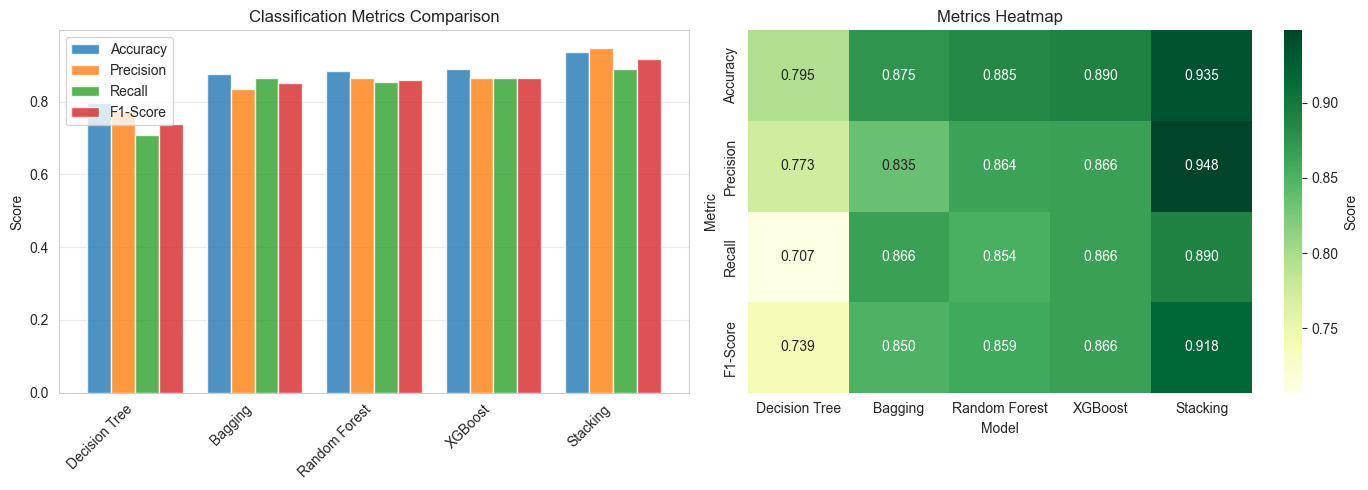


Visualisations generated successfully.


In [11]:
# plot performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar plot of metrics
ax = axes[0]
x = np.arange(len(df_class_res))
width = 0.2

ax.bar(
  x - 1.5*width,
  df_class_res['Accuracy'],
  width,
  label='Accuracy',
  alpha=0.8
)
ax.bar(
  x - 0.5*width,
  df_class_res['Precision'],
  width,
  label='Precision',
  alpha=0.8
)
ax.bar(
  x + 0.5*width,
  df_class_res['Recall'],
  width,
  label='Recall',
  alpha=0.8
)
ax.bar(
  x + 1.5*width,
  df_class_res['F1-Score'],
  width,
  label='F1-Score',
  alpha=0.8
)

ax.set_ylabel('Score')
ax.set_title('Classification Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(
  df_class_res['Model'],
  rotation=45,
  ha='right'
)
ax.legend()
ax.grid(axis='y', alpha=0.4)
ax.tick_params(axis='x', which='both', gridOn=False)

# heatmap of metrics
ax = axes[1]
metrics_data = df_class_res[[
  'Accuracy',
  'Precision',
  'Recall',
  'F1-Score'
]].set_index(
  df_class_res['Model']
)

sns.heatmap(
  metrics_data.T,
  annot=True,
  fmt='.3f',
  cmap='YlGn',
  ax=ax,
  cbar_kws={'label': 'Score'}
)
ax.set_title('Metrics Heatmap')
ax.set_xlabel('Model')
ax.set_ylabel('Metric')

plt.tight_layout()
plt.show()

print("\nVisualisations generated successfully.")

#### 1.6 Feature importance analysis

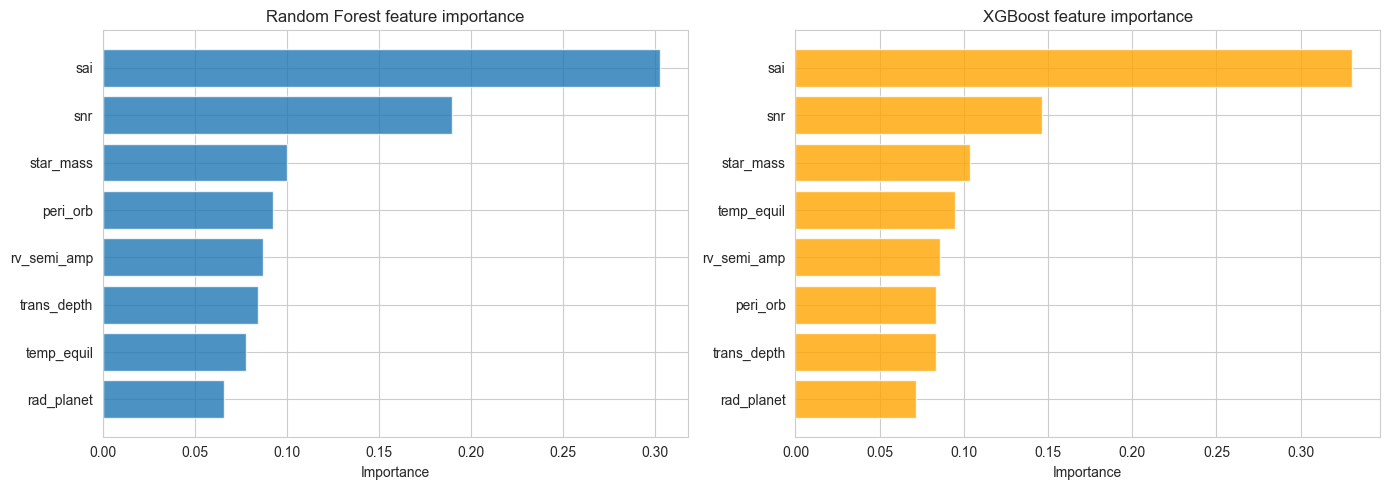

Feature importance analysis complete.


In [12]:
# extract feature importance from tree-based models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# random Forest feature importance
rf_importance = rf_class.feature_importances_
sorted_idx = np.argsort(rf_importance)[::-1]

ax = axes[0]
ax.barh(
  [feature_names[i] for i in sorted_idx],
  rf_importance[sorted_idx],
  alpha=0.8
)
ax.set_xlabel('Importance')
ax.set_title('Random Forest feature importance')
ax.invert_yaxis()

# XGBoost feature importance
xgb_importance = xgb_class.feature_importances_
sorted_idx_xgb = np.argsort(xgb_importance)[::-1]

ax = axes[1]
ax.barh(
  [feature_names[i] for i in sorted_idx_xgb],
  xgb_importance[sorted_idx_xgb],
  alpha=0.8,
  color='orange'
)
ax.set_xlabel('Importance')
ax.set_title('XGBoost feature importance')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("Feature importance analysis complete.")

#### 1.7 Using five-fold cross validation

In [13]:
cv = StratifiedKFold(
  n_splits=5,
  shuffle=True,
  random_state=RND_STATE,
)

models_class_cv = {
  'Decision Tree': DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=RND_STATE,
  ),
  'Bagging': BaggingClassifier(
    estimator=DecisionTreeClassifier(
      max_depth=10,
      random_state=RND_STATE
    ),
    n_estimators=10,
    max_features=1.0,
    max_samples=1.0,
    random_state=RND_STATE,
    n_jobs=-1
  ),
  'Random Forest': RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=8,
    random_state=RND_STATE,
    n_jobs=-1,
  ),
  'XGBoost': xgb.XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_lambda=1.0,
    random_state=RND_STATE,
    verbosity=0,
  ),
}

title = "5-fold CV (F1-score, classification)".upper() 
lentit = len(title)
print(title)
print('-' * lentit)
for name, model in models_class_cv.items():
  scores = cross_val_score(
    model,
    X_class,
    y_class,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
  )
  print(
    f"{name:15s} "
    f"mean = {scores.mean():.3f} "
    f"± {scores.std():.3f}"
  )

5-FOLD CV (F1-SCORE, CLASSIFICATION)
------------------------------------
Decision Tree   mean = 0.743 ± 0.051
Bagging         mean = 0.827 ± 0.051
Random Forest   mean = 0.843 ± 0.040
XGBoost         mean = 0.840 ± 0.040


##### Notes on the cross-validation

In CV context, each fold is trained independently, so they can run in parallel:
- `n_jobs=-1` means: use all available CPU cores in parallel.
- `n_jobs=1` (default) → single core (slow).
- `n_jobs=-2` → use all but one core (reserve one for other tasks).

##### Notes on the hyper-parameters

For **decision trees**:

- `max_depth`: maximum number of levels the tree can grow; a tree of
  `max_depth=3` can have at most three splits from root to leaf.
  - `max_depth=1` → single split (stumpy tree).
  - `max_depth=10` → deeper, more complex tree.
  - Smaller values = simpler trees = less variance, more bias.
  - Larger values = complex trees = more variance, less bias.

- `min_samples_split`: minimum number of samples required at a node to attempt a
  split; if a node has fewer samples, it becomes a leaf (stops growing).
  - `min_samples_split=2` → every node with ≥ 2 samples can split (aggressive
    growth).
  - `min_samples_split=20` → only nodes with ≥ 20 samples split (conservative,
    smoother trees).
  - Larger values = regularisation (less overfitting) but risk underfitting.
  - Rule of thumb: start with 5–10% of training set size.

- `min_samples_leaf`: minimum number of samples required to be at a leaf node;
  after a split, both resulting nodes must have ≥ this many samples; otherwise
  the split is rejected.
  - `min_samples_leaf=1` → leaves can contain just one sample (low
    regularisation).
  - `min_samples_leaf=10` → every leaf must have ≥ 10 samples (high
    regularisation, smoother boundaries).
  - Larger values = prevents trees from creating isolated leaves = better
    generalisation.

All the three hyper-parameters above work together to control the model's
complexity.
Typically:
- We should start with defaults (`max_depth=None`, `min_samples_split=2`,
  `min_samples_leaf=1`);
- If overfitting: we decrease the `max_depth` limit, raise `min_samples_split`,
  or raise `min_samples_leaf`.

**Ensemble control hyperparameters**:

- `n_estimators`: number of base models (trees) in the ensemble.
  - `n_estimators=50` → train 50 trees, average predictions.
  - `n_estimators=200` → train 200 trees (more computation, usually better
    stability).
  - More estimators generally improve performance up to a plateau (diminishing
    returns around 100–300).

- `max_samples`: number (or fraction) of samples to draw with replacement when
  training each base tree.
  - `max_samples=1.0` or `max_samples=800` → draw 800 samples per tree (= full
    data set size, bootstrap, standard).
  - `max_samples=0.5` or `max_samples=400` → draw 400 samples per tree (lower
    variance per tree, but less data).
  - Usually we keep it at 1.0 (full data set); the randomness comes from which
    samples are drawn.

- `max_features`: number (or fraction) of features to consider when splitting at
  each node in each tree.
  - `max_features=1.0` or `'auto'` → consider all features (standard for
    bagging).
  - `max_features='sqrt'` → consider √(`n_features`) at each split (adds extra
    randomness, key to Random Forest).
  - `max_features=0.5` → consider 50% of features (even more randomness).
  - Smaller values → more diversity in trees → more variance reduction, but risk
    higher bias.
  - For **Bagging**: we usually set `max_samples=1.0`, `max_features=1.0`
    (minimal feature randomness; diversity comes from bootstrap).
  - For **Random Forest**: we set `max_features='sqrt'` (or `'log2'` for
    regression) to get the extra randomness that defines RF.

**Boosting specific hyper-parameters**:

- `learning_rate` (aka shrinkage, step size): fraction by which each new tree's
  contribution is scaled.
  - `learning_rate=1.0` → each tree's full prediction is added.
  - `learning_rate=0.1` → each tree contributes only 10% of its prediction
    (slow, careful learning).
  - Smaller values = more iterations needed but often better generalisation;
    standard: 0.01–0.3.

- `subsample`: fraction of training samples used to train each tree (like
  bagging, but without replacement).
- `subsample=1.0` → use all samples for each tree.
- `subsample=0.8` → randomly sample 80% of data for each tree.
- Lower values add randomness and reduce overfitting; typical: 0.5–1.0.

- `colsample_bytree`: fraction of features randomly sampled for each tree
  (analogous to `max_features` in RF).
  - `colsample_bytree=1.0` → use all features.
  - `colsample_bytree=0.8` → randomly select 80% of features per tree.
  - Adds diversity; typical: 0.5–1.0.

- `reg_lambda` (L2 regularisation): penalises model complexity (leaf weights).
  - `reg_lambda=0` → no penalty (can overfit).
  - `reg_lambda=1.0` → moderate penalty.
  - `reg_lambda=10.0` → strong penalty (simpler, more conservative model).
  - Higher values = more regularisation = less overfitting but risk
    underfitting.

These hyper-parameters control how trees are built sequentially and regularised.
They matter in boosting because each tree is added sequentially, so we need both
randomness (via `subsample`, `colsample_bytree`) and `regularisation` (via
`learning_rate`, `reg_lambda`) to prevent the ensemble from chasing noise too
aggressively.

##### Notes on the stacking method

In stacking, base learners should be diverse.
This means that the base learners should make different types of errors, so the
meta-learner can learn complementary patterns.

Example of good diversity:
- Decision Tree (axis-aligned splits, captures local patterns).
- SVM with RBF kernel (smoother, non-linear boundaries, global perspective).
- K-NN (local, instance-based).

Each makes errors in different regions of the feature space.
The meta-learner (logistic regression) learns that when the tree says 1 but the
SVM says 0, it should trust the SVM more (or vice versa).

Example of poor diversity:
- Random Forest (200 trees).
- Random Forest (100 trees).
- Random Forest (50 trees).

All three are essentially the same algorithm with different `n_estimators`.
They fail in similar ways.
The meta-learner has little to learn.

---
## Part II: Regression Task
### 2. Stellar luminosity estimation

We simulate a data set for estimating stellar luminosity based on spectral
characteristics and physical parameters.
The task is to predict the luminosity of a star given its observables.

**Context**

In spectroscopy and exoplanet characterisation, accurate stellar
luminosity is essential for determining the habitability of planets and
constraining stellar evolution models.
Machine learning can provide quick estimates from broad-band photometry and
spectral features.

#### 2.1 Generate mock stellar regression data set

In [14]:
# generate synthetic stellar luminosity regression data set
X_reg, y_reg = make_regression(
  n_samples=10000,
  n_features=8,
  n_informative=6,
  noise=50.0,
  random_state=RND_STATE
)

# create feature names
feature_names_reg = [
  "t_eff", # effective temperature (K)
  "log_g", # surface gravity
  "met", # [Fe/H] (dex)
  "mag_v", # V-band magnitude
  "bv_ci", # B-V colour index
  "paral", # parallax (mas)
  "spec_idx", # spectral index
  "prot", # rotation period (days)
]

# scale and prepare features
scaler_reg = StandardScaler()
X_reg = scaler_reg.fit_transform(X_reg)

# scale target variable (luminosity in solar units)
y_reg = (y_reg - y_reg.mean()) / y_reg.std() + 0.5
# ensure positive luminosity
y_reg = np.abs(y_reg)

# create data frame
df_reg = pd.DataFrame(X_reg, columns=feature_names_reg)
df_reg["luminosity"] = y_reg

title = "STELLAR LUMINOSITY DATA SET"
lenti = len(title)
print('='*lenti)
print(title)
print("-"*lenti + '\n')
print(f"Shape: {df_reg.shape}")
print(f"\nLuminosity statistics:")
print(df_reg['luminosity'].describe())
print(f"\nFirst few rows:")
print(df_reg.head())
print("="*80)

STELLAR LUMINOSITY DATA SET
---------------------------

Shape: (10000, 9)

Luminosity statistics:
count    10000.000000
mean         0.899792
std          0.663640
min          0.000063
25%          0.365555
50%          0.774497
75%          1.300674
max          4.002239
Name: luminosity, dtype: float64

First few rows:
      t_eff     log_g       met     mag_v     bv_ci     paral  spec_idx  \
0 -0.271479 -0.187370 -0.305528  0.163429  0.331135 -0.005020  0.101691   
1 -0.222567 -0.198017  0.572027  1.939619 -1.399706  0.812558  1.187668   
2 -1.339244 -0.950150  0.949401  0.380108 -0.982284  0.380326  1.689616   
3  0.561395  1.465645  0.586779  0.831519 -0.491759  0.184298  0.298028   
4  0.749557 -0.914160  0.326567  0.761310 -0.821123  2.169643  0.027690   

       prot  luminosity  
0 -0.857324    0.131963  
1  0.620842    2.793365  
2  0.480229    1.747008  
3  2.471634    2.304332  
4 -1.059020    0.785616  


##### Note

`noise = 50` corresponds to the standard deviation of the Gaussian noise applied
to the output.

#### 2.2 Split data

In [15]:
# split data into training and testing sets
X_reg_trn, X_reg_tst, y_reg_trn, y_reg_tst = (
  train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=RND_STATE
  )
)

print(f"Training set size: {X_reg_trn.shape[0]}")
print(f"Test set size: {X_reg_tst.shape[0]}")

Training set size: 8000
Test set size: 2000


#### 2.3 Train individual regression models

##### 2.3.1 Decision Tree Regressor or Regression Tree (baseline)

In [16]:
dt_reg = DecisionTreeRegressor(
  max_depth=8,
  min_samples_split=50,
  min_samples_leaf=6,
  random_state=RND_STATE
)
dt_reg.fit(X_reg_trn, y_reg_trn)
y_pred_dt_reg = dt_reg.predict(X_reg_tst)

mse_dt = mean_squared_error(y_reg_tst, y_pred_dt_reg)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_reg_tst, y_pred_dt_reg)
mae_dt = mean_absolute_error(y_reg_tst, y_pred_dt_reg)

title = "Stellar Luminosity – Decision Tree"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"R² Score: {r2_dt:.4f}")
print(f"RMSE: {rmse_dt:.4f}")
print(f"MAE: {mae_dt:.4f}")

Stellar Luminosity – Decision Tree
----------------------------------
R² Score: 0.5557
RMSE: 0.4394
MAE: 0.3509


##### 2.3.2 Bagging

In [17]:
bagging_reg = BaggingRegressor(
  estimator=DecisionTreeRegressor(
    max_depth=20,
    min_samples_leaf=1
  ),
  n_estimators=50,
  max_samples=1.0,
  max_features=1.0,
  random_state=RND_STATE,
  # n_jobs=None
  n_jobs=-1
)
bagging_reg.fit(X_reg_trn, y_reg_trn)
y_pred_bagging_reg = bagging_reg.predict(X_reg_tst)

mse_bagging = mean_squared_error(y_reg_tst, y_pred_bagging_reg)
rmse_bagging = np.sqrt(mse_bagging)
r2_bagging = r2_score(y_reg_tst, y_pred_bagging_reg)
mae_bagging = mean_absolute_error(y_reg_tst, y_pred_bagging_reg)

title = "Stellar Luminosity – Bagging"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"R² Score: {r2_bagging:.4f}")
print(f"RMSE: {rmse_bagging:.4f}")
print(f"MAE: {mae_bagging:.4f}")

Stellar Luminosity – Bagging
----------------------------
R² Score: 0.7690
RMSE: 0.3168
MAE: 0.2514


##### 2.3.3 Random Forest regressor

In [18]:
rf_reg = RandomForestRegressor(
  n_estimators=300,
  max_depth=50,
  min_samples_split=5,
  min_samples_leaf=1,
  max_features=1.0,
  random_state=RND_STATE,
  n_jobs=-1
)
rf_reg.fit(X_reg_trn, y_reg_trn)
y_pred_rf_reg = rf_reg.predict(X_reg_tst)

mse_rf = mean_squared_error(y_reg_tst, y_pred_rf_reg)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_reg_tst, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_reg_tst, y_pred_rf_reg)

title = "Stellar Luminosity – Random Forest"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"R² Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

Stellar Luminosity – Random Forest
----------------------------------
R² Score: 0.7738
RMSE: 0.3135
MAE: 0.2484


##### 2.3.4 XGBoost regressor

In [19]:
xgb_reg = xgb.XGBRegressor(
  n_estimators=150,
  max_depth=6,
  learning_rate=0.1,
  subsample=0.8,
  colsample_bytree=1.0,
  reg_lambda=1.0,
  random_state=RND_STATE,
  n_jobs=-1,
  verbosity=0
)
xgb_reg.fit(
  X_reg_trn,
  y_reg_trn,
  eval_set=[(X_reg_tst, y_reg_tst)],
  verbose=False
)
y_pred_xgb_reg = xgb_reg.predict(X_reg_tst)

mse_xgb = mean_squared_error(y_reg_tst, y_pred_xgb_reg)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_reg_tst, y_pred_xgb_reg)
mae_xgb = mean_absolute_error(y_reg_tst, y_pred_xgb_reg)

title = "Stellar Luminosity – XGBoost Regressor"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"R² Score: {r2_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")

Stellar Luminosity – XGBoost Regressor
--------------------------------------
R² Score: 0.7935
RMSE: 0.2995
MAE: 0.2392


##### 2.3.5 Stacking Regressor

In [20]:
# define base learners (diverse models)
base_learners_reg = [
  (
    'dt', DecisionTreeRegressor(
      max_depth=8,
      random_state=RND_STATE
    )
  ),
  (
    'svmr', SVR(
      kernel='rbf',
      gamma='scale'
    )
  ),
  (
    'knn', KNeighborsRegressor(n_neighbors=10)
  )
]

# define meta-learner
meta_learner_reg = LinearRegression()

# create stacking regressor
stacking_reg = StackingRegressor(
  estimators=base_learners_reg,
  final_estimator=meta_learner_reg,
  cv=5
)
stacking_reg.fit(X_reg_trn, y_reg_trn)
y_pred_stacking_reg = stacking_reg.predict(X_reg_tst)

mse_stacking = mean_squared_error(
  y_reg_tst,
  y_pred_stacking_reg
)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_reg_tst, y_pred_stacking_reg)
mae_stacking = mean_absolute_error(
  y_reg_tst,
  y_pred_stacking_reg
)

title = "Stellar Luminosity – Stacking Regressor"
lenti = len(title)
print(title)
print("-"*lenti)
print(f"R² Score: {r2_stacking:.4f}")
print(f"RMSE: {rmse_stacking:.4f}")
print(f"MAE: {mae_stacking:.4f}")

Stellar Luminosity – Stacking Regressor
---------------------------------------
R² Score: 0.8107
RMSE: 0.2868
MAE: 0.2268


#### 2.4 Comprehensive regression results

In [21]:
# compile results for regression models
reg_res = {
  'Model': [
    'Decision Tree',
    'Bagging',
    'Random Forest',
    'XGBoost',
    'Stacking'
  ],
  'R² Score': [r2_dt, r2_bagging, r2_rf, r2_xgb, r2_stacking],
  'RMSE': [rmse_dt, rmse_bagging, rmse_rf, rmse_xgb, rmse_stacking],
  'MAE': [mae_dt, mae_bagging, mae_rf, mae_xgb, mae_stacking]
}

df_reg_res = pd.DataFrame(reg_res)
print('\n' + "="*43)
print("Regression Results Summary")
print("-"*43)
print(df_reg_res.to_string(index=False))
best_idx = df_reg_res['R² Score'].idxmax()
print("-"*43)
print(f"Best Model (R² Score): {df_reg_res.loc[best_idx, 'Model']}")
print("="*43)


Regression Results Summary
-------------------------------------------
        Model  R² Score     RMSE      MAE
Decision Tree  0.555722 0.439397 0.350947
      Bagging  0.769037 0.316812 0.251446
Random Forest  0.773790 0.313534 0.248409
      XGBoost  0.793547 0.299530 0.239190
     Stacking  0.810661 0.286847 0.226817
-------------------------------------------
Best Model (R² Score): Stacking


#### 2.5 Visualisation of regression results

Regression visualisations generated successfully.


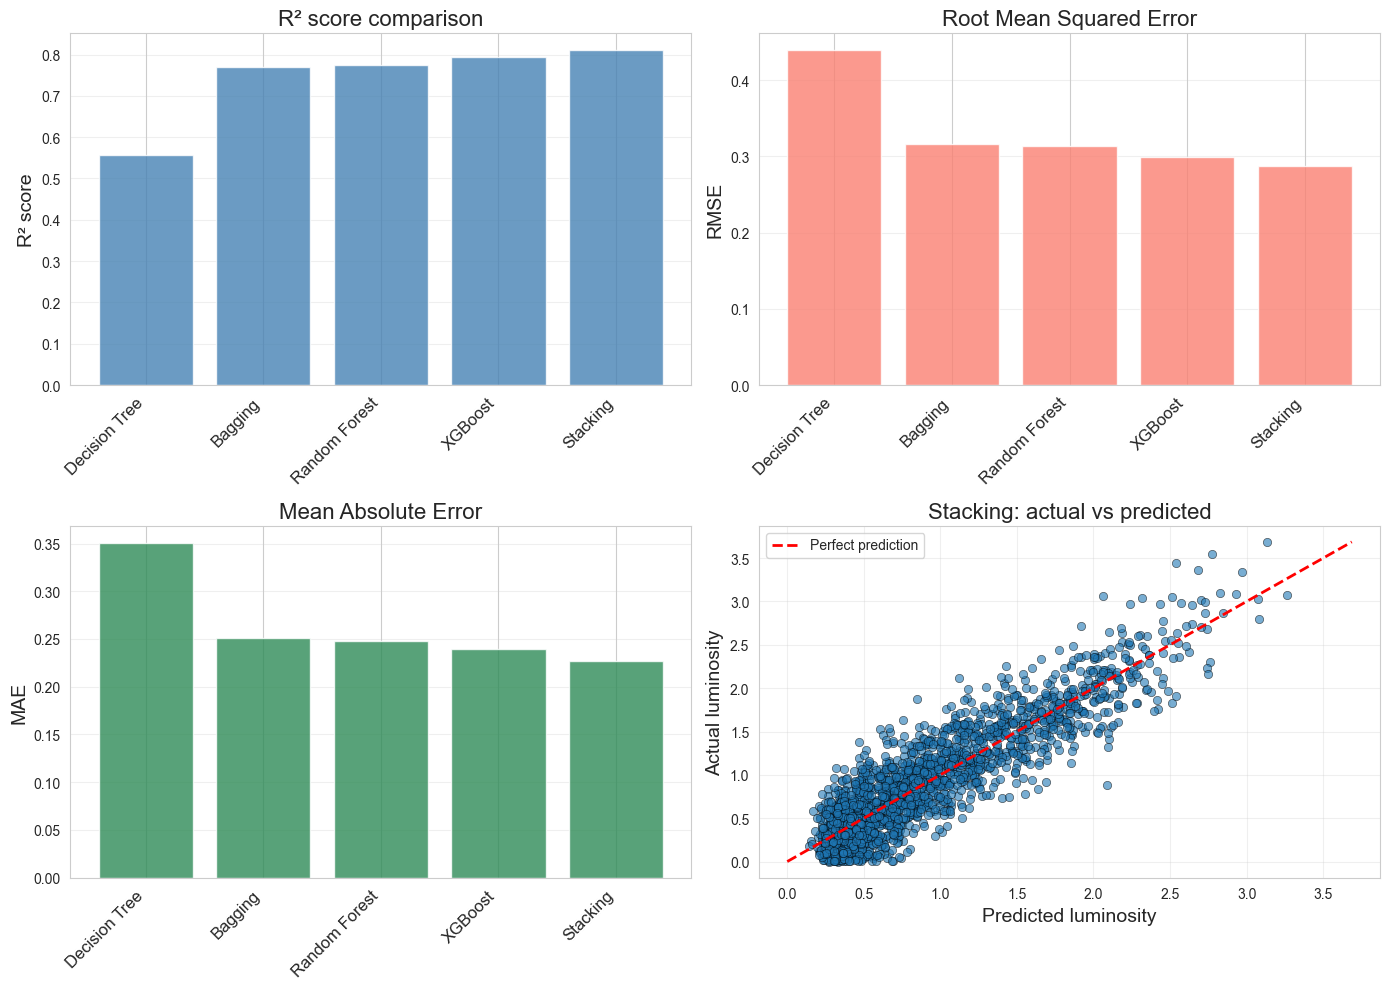

In [22]:
# plot regression performance comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² Score comparison
ax = axes[0, 0]
ax.bar(
  df_reg_res['Model'],
  df_reg_res['R² Score'],
  alpha=0.8,
  color='steelblue'
)
ax.set_ylabel('R² score', fontsize=14)
ax.set_title('R² score comparison', fontsize=16)
ax.set_xticklabels(
  df_reg_res['Model'],
  rotation=45,
  ha='right',
  fontsize=12
)
ax.grid(axis='y', alpha=0.3)

# RMSE comparison
ax = axes[0, 1]
ax.bar(
  df_reg_res['Model'],
  df_reg_res['RMSE'],
  alpha=0.8,
  color='salmon'
)
ax.set_ylabel('RMSE', fontsize=14)
ax.set_title('Root Mean Squared Error', fontsize=16)
ax.set_xticklabels(
  df_reg_res['Model'],
  rotation=45,
  ha='right',
  fontsize=12
)
ax.grid(axis='y', alpha=0.3)

# MAE comparison
ax = axes[1, 0]
ax.bar(
  df_reg_res['Model'],
  df_reg_res['MAE'],
  alpha=0.8,
  color='seagreen'
)
ax.set_ylabel('MAE', fontsize=14)
ax.set_title('Mean Absolute Error', fontsize=16)
ax.set_xticklabels(
  df_reg_res['Model'],
  rotation=45,
  ha='right',
  fontsize=12
)
ax.grid(axis='y', alpha=0.3)

# predicted vs actual (best model)
ax = axes[1, 1]
ax.scatter(
  y_pred_stacking_reg,
  y_reg_tst,
  alpha=0.6,
  edgecolors='k',
  linewidth=0.5
)
# perfect prediction line
min_val = min(y_reg_tst.min(), y_pred_xgb_reg.min())
max_val = max(y_reg_tst.max(), y_pred_xgb_reg.max())
ax.plot(
  [min_val, max_val],
  [min_val, max_val],
  'r--',
  lw=2,
  label="Perfect prediction"
)
ax.set_xlabel("Predicted luminosity", fontsize=14)
ax.set_ylabel("Actual luminosity", fontsize=14)
ax.set_title("Stacking: actual vs predicted", fontsize=16)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

print("Regression visualisations generated successfully.")

#### 2.6 Residual analysis

Residual analysis complete.


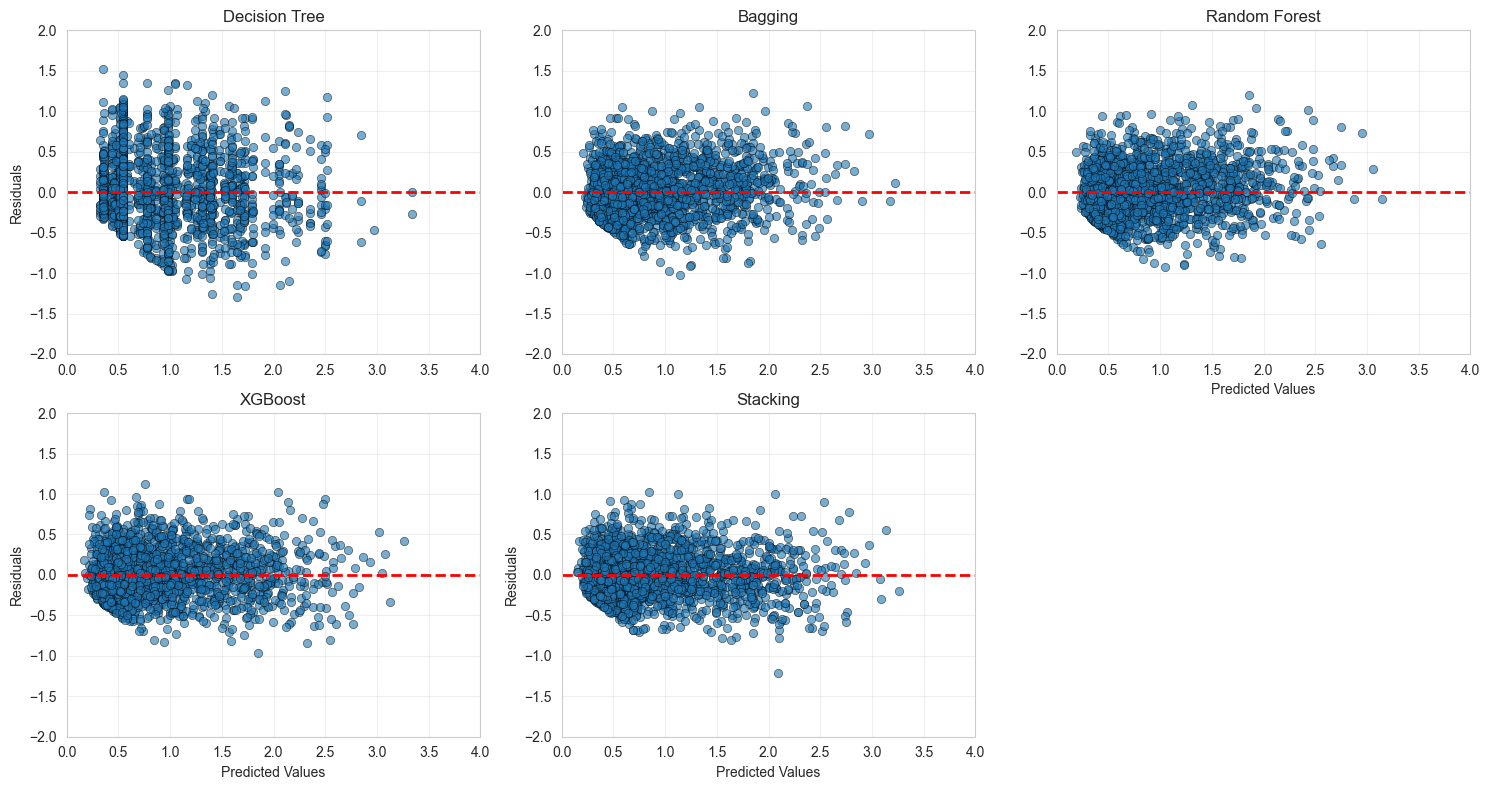

In [23]:
residuals_list = [
  y_reg_tst - y_pred_dt_reg,
  y_reg_tst - y_pred_bagging_reg,
  y_reg_tst - y_pred_rf_reg,
  y_reg_tst - y_pred_xgb_reg,
  y_reg_tst - y_pred_stacking_reg
]

models_list = [
  'Decision Tree',
  'Bagging',
  'Random Forest',
  'XGBoost',
  'Stacking'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (residuals, model_name) in enumerate(
  zip(residuals_list, models_list)
):
  ax = axes[idx]
  ax.scatter(
    y_pred_dt_reg if idx == 0 else y_pred_bagging_reg
    if idx == 1 else y_pred_rf_reg
    if idx == 2 else y_pred_xgb_reg
    if idx == 3 else y_pred_stacking_reg,
    residuals,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.5
  )
  ax.axhline(y=0, color='r', linestyle='--', lw=2)
  ax.set_xlabel('Predicted Values')
  ax.set_ylabel('Residuals')
  ax.set_title(f'{model_name}')
  ax.grid(alpha=0.3)

  # set uniform scales for ALL plots
  ax.set_xlim(0, 4.0)
  ax.set_ylim(-2, 2)

  # hide x-labels on top row (idx 0-2)
  if idx < 2:
    ax.set_xlabel('')
  else:
    ax.set_xlabel('Predicted Values')
  
  # hide y-labels on inner columns
  if idx in [1, 2]:
    ax.set_ylabel('')
  else:
    ax.set_ylabel('Residuals')

# remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()

print("Residual analysis complete.")

#### 2.7 Five-fold cross-validation

In [24]:
cv_reg = KFold(
  n_splits=5,
  shuffle=True,
  random_state=RND_STATE,
)

models_reg_cv = {
  'Decision Tree': DecisionTreeRegressor(
    max_depth=10,
    random_state=RND_STATE,
  ),
  'Random Forest': RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=RND_STATE,
    n_jobs=-1,
  ),
  'XGBoost': xgb.XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_STATE,
    verbosity=0,
  ),
}

print("5-fold CV (R² score, regression)".upper())
print('-' * 37)
for name, model in models_reg_cv.items():
  scores = cross_val_score(
    model,
    X_reg,
    y_reg,
    cv=cv_reg,
    scoring='r2',
    n_jobs=-1,
  )
  print(
    f"{name:15s} "
    f"mean = {scores.mean():.3f} "
    f"± {scores.std():.3f}"
  )

5-FOLD CV (R² SCORE, REGRESSION)
-------------------------------------
Decision Tree   mean = 0.566 ± 0.016
Random Forest   mean = 0.727 ± 0.008
XGBoost         mean = 0.779 ± 0.012


---

## Summary and key takeaways

### Classification task (exoplanet detection)

In [25]:
print("\n" + "="*66)
print("SUMMARY: EXOPLANET DETECTION CLASSIFICATION")
print("-" * 66)
print("\nKey observations")
print("-" * 66)

# find best model
best_class_idx = df_class_res['F1-Score'].idxmax()
best_class = df_class_res.loc[best_class_idx, 'Model']
best_f1 = df_class_res.loc[best_class_idx, 'F1-Score']

print(f"\n1. Best performing model: {best_class}")
print(f"   F1-Score: {best_f1:.4f}")

improvement = (
  (best_f1 - df_class_res.loc[0, 'F1-Score']) /
  df_class_res.loc[0, 'F1-Score'] * 100
)
print(f"   Improvement over Decision Tree: {improvement:.1f}%")

print(f"\n2. Ensemble methods comparison:")
for idx, row in df_class_res.iterrows():
  print(
    f"   {row['Model']:20s}: "
    f"Accuracy={row['Accuracy']:.4f}, "
    f"F1={row['F1-Score']:.4f}"
  )

print(f"\n3. All ensemble methods outperform the baseline decision tree.")
print("="*66)

print("\n\n" + "="*66)
print("SUMMARY: STELLAR LUMINOSITY REGRESSION")
print("-"*66)
print("\nKey observations")
print("-" * 66)

# find best model
best_reg_idx = df_reg_res['R² Score'].idxmax()
best_reg = df_reg_res.loc[best_reg_idx, 'Model']
best_r2 = df_reg_res.loc[best_reg_idx, 'R² Score']

print(f"\n1. Best performing model: {best_reg}")
print(f"   R² Score: {best_r2:.4f}")

improvement_reg = (
  (best_r2 - df_reg_res.loc[0, 'R² Score']) /
  abs(df_reg_res.loc[0, 'R² Score']) * 100
)
print(f"   Improvement over Decision Tree: {improvement_reg:.1f}%")

print(f"\n2. Ensemble methods comparison (R² Score):")
for idx, row in df_reg_res.iterrows():
  print(
    f"   {row['Model']:20s}: "
    f"R²={row['R² Score']:.4f}, "
    f"RMSE={row['RMSE']:.4f}, "
    f"MAE={row['MAE']:.4f}"
  )

print(f"\n3. Ensemble methods significantly reduce prediction error.")


SUMMARY: EXOPLANET DETECTION CLASSIFICATION
------------------------------------------------------------------

Key observations
------------------------------------------------------------------

1. Best performing model: Stacking
   F1-Score: 0.9182
   Improvement over Decision Tree: 24.3%

2. Ensemble methods comparison:
   Decision Tree       : Accuracy=0.7950, F1=0.7389
   Bagging             : Accuracy=0.8750, F1=0.8503
   Random Forest       : Accuracy=0.8850, F1=0.8589
   XGBoost             : Accuracy=0.8900, F1=0.8659
   Stacking            : Accuracy=0.9350, F1=0.9182

3. All ensemble methods outperform the baseline decision tree.


SUMMARY: STELLAR LUMINOSITY REGRESSION
------------------------------------------------------------------

Key observations
------------------------------------------------------------------

1. Best performing model: Stacking
   R² Score: 0.8107
   Improvement over Decision Tree: 45.9%

2. Ensemble methods comparison (R² Score):
   Decision Tre

### Practical recommendations for astrophysical applications

In [26]:
print("\n" + "="*66)
print("PRACTICAL RECOMMENDATIONS")
print("-"*66)

recommendations = """
1. BAGGING
   ✓ When: We have high-variance models (e.g., deep decision trees)
   ✓ When: We need fast training with parallelisation
   ✗ When: Our base model has high bias
   Example: Quick exoplanet candidate filtering

2. RANDOM FOREST
   ✓ When: We need interpretability (feature importance)
   ✓ When: We have categorical and mixed-type features
   ✓ When: Computational resources are limited
   Example: Feature analysis for stellar parameters

3. XGBOOST
   ✓ When: We want maximum predictive accuracy
   ✓ When: We have complex non-linear relationships
   ✗ When: Interpretability is critical (but richer feature-importance tooling)
   Example: High-precision luminosity or mass estimation

4. STACKING
   ✓ When: We have diverse model types available
   ✓ When: We have enough data for cross-validation
   ✗ When: Training time is critical
   Example: Combining spectroscopy + photometry models

5. GENERAL GUIDELINES
   • Always use cross-validation to avoid overfitting
   • Ensemble methods require hyperparameter tuning
   • More estimators ≠ always better (diminishing returns)
   • Monitor for overfitting on validation data
   • Document your choice for reproducibility
"""

print(recommendations)
print("="*66)


PRACTICAL RECOMMENDATIONS
------------------------------------------------------------------

1. BAGGING
   ✓ When: We have high-variance models (e.g., deep decision trees)
   ✓ When: We need fast training with parallelisation
   ✗ When: Our base model has high bias
   Example: Quick exoplanet candidate filtering

2. RANDOM FOREST
   ✓ When: We need interpretability (feature importance)
   ✓ When: We have categorical and mixed-type features
   ✓ When: Computational resources are limited
   Example: Feature analysis for stellar parameters

3. XGBOOST
   ✓ When: We want maximum predictive accuracy
   ✓ When: We have complex non-linear relationships
   ✗ When: Interpretability is critical (but richer feature-importance tooling)
   Example: High-precision luminosity or mass estimation

4. STACKING
   ✓ When: We have diverse model types available
   ✓ When: We have enough data for cross-validation
   ✗ When: Training time is critical
   Example: Combining spectroscopy + photometry models



---
## Further Exploration

### Suggested exercises for deeper understanding:

1. **Hyperparameter tuning**: Use `GridSearchCV` or `RandomizedSearchCV`
   to optimise ensemble parameters (e.g., `n_estimators`, `max_depth`)

2. **Cross-validation**: Implement k-fold cross-validation for more
   robust evaluation

3. **Feature importance**: Analyse which features are most influential
   in ensemble predictions

4. **Learning curves**: Visualise how performance changes with training
   set size

5. **Real data sets**: Apply these methods to actual astronomical data
   from Kaggle or NASA archives (Kepler, TESS, Gaia)

6. **Model explanation**: Use SHAP or LIME to understand individual
   predictions

7. **Ensemble diversity**: Experiment with different base learners
   to understand diversity's role

In [27]:
# code snippet for hyperparameter search with CV
from sklearn.model_selection import GridSearchCV

param_grid = {
  'max_depth': range(1, 11),
  'min_samples_leaf': range(1, 11),
  'min_samples_split': range(1, 31)
}

grid_search = GridSearchCV(
  DecisionTreeClassifier(random_state=RND_STATE),
  param_grid,
  cv=5,
  scoring='f1',
  n_jobs=-1,
)

grid_search.fit(X_class_trn, y_class_trn)

print(grid_search.best_params_)      # best hyperparameters
print(f"CV score at best params: {grid_search.best_score_:.5f}")

{'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 18}
CV score at best params: 0.79706


### References for further reading:

- Scikit-learn Ensemble Methods Documentation
- XGBoost Documentation and Tutorials
- [Ensemble Methods as a Defense to Adversarial Perturbations](https://arxiv.org/pdf/1709.03423)
- [Ignorance is not Bliss: A Novel Ensemble Method to Counter Adversarial Attacks on Deep Learning Models](https://dl.acm.org/doi/10.1145/3703323.3703336)
- [Kaggle competition winning solutions](https://www.kaggle.com/code/sudalairajkumar/winning-solutions-of-kaggle-competitions) (often use ensembles)

---

**End of hands-on session for the ICE Machine Learning Journal Club**

Nuno R. C. Gomes, Barcelona, 2026/02/13
